# Uber Pickups

## Install & import data

In [2]:
# Load in our libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, date, time

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.offline import plot
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
#pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.cluster import KMeans, DBSCAN

In [3]:
list_data_14 = ['apr14', 'may14', 'jun14', 'jul14', 'aug14', 'sep14']
path_file = 'uber-trip-data/uber-raw-data-'
type_file = '.csv'
for i in range(len(list_data_14)):
    if i == 0:
        data = pd.read_csv(path_file + list_data_14[i] + type_file)
    else:
        month_data = pd.read_csv(path_file + list_data_14[i] + type_file)
        data = pd.concat([data, month_data], axis=0, ignore_index=True)
data

Date/Time      Lat      Lon    Base
0          4/1/2014 0:11:00  40.7690 -73.9549  B02512
1          4/1/2014 0:17:00  40.7267 -74.0345  B02512
2          4/1/2014 0:21:00  40.7316 -73.9873  B02512
3          4/1/2014 0:28:00  40.7588 -73.9776  B02512
4          4/1/2014 0:33:00  40.7594 -73.9722  B02512
...                     ...      ...      ...     ...
4534322  9/30/2014 22:57:00  40.7668 -73.9845  B02764
4534323  9/30/2014 22:57:00  40.6911 -74.1773  B02764
4534324  9/30/2014 22:58:00  40.8519 -73.9319  B02764
4534325  9/30/2014 22:58:00  40.7081 -74.0066  B02764
4534326  9/30/2014 22:58:00  40.7140 -73.9496  B02764

[4534327 rows x 4 columns]

## EDA

In [5]:
# Basic stats
print("Set with labels (our train+test) : {}".format(data.shape))
print()

print("Display of dataset: ")
display(data.head())
print()

print("Basics statistics: ")
data_desc = data.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*data.isnull().sum()/data.shape[0])


Set with labels (our train+test) : (4534327, 4)

Display of dataset: 


Date/Time      Lat      Lon    Base
0  4/1/2014 0:11:00  40.7690 -73.9549  B02512
1  4/1/2014 0:17:00  40.7267 -74.0345  B02512
2  4/1/2014 0:21:00  40.7316 -73.9873  B02512
3  4/1/2014 0:28:00  40.7588 -73.9776  B02512
4  4/1/2014 0:33:00  40.7594 -73.9722  B02512


Basics statistics: 


Date/Time           Lat           Lon     Base
count             4534327  4.534327e+06  4.534327e+06  4534327
unique             260093           NaN           NaN        5
top     4/7/2014 20:21:00           NaN           NaN   B02617
freq                   97           NaN           NaN  1458853
mean                  NaN  4.073926e+01 -7.397302e+01      NaN
std                   NaN  3.994991e-02  5.726670e-02      NaN
min                   NaN  3.965690e+01 -7.492900e+01      NaN
25%                   NaN  4.072110e+01 -7.399650e+01      NaN
50%                   NaN  4.074220e+01 -7.398340e+01      NaN
75%                   NaN  4.076100e+01 -7.396530e+01      NaN
max                   NaN  4.211660e+01 -7.206660e+01      NaN


Percentage of missing values: 


Date/Time    0.0
Lat          0.0
Lon          0.0
Base         0.0
dtype: float64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4534327 entries, 0 to 4534326
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Date/Time  object 
 1   Lat        float64
 2   Lon        float64
 3   Base       object 
dtypes: float64(2), object(2)
memory usage: 138.4+ MB


In [7]:
data['Base'].value_counts()

B02617    1458853
B02598    1393113
B02682    1212789
B02764     263899
B02512     205673
Name: Base, dtype: int64

In [8]:
data['Timestamp'] = pd.to_datetime(data['Date/Time'], format='%m/%d/%Y %H:%M:%S')
data['Dayofweek'] = data['Timestamp'].apply(lambda x: x.dayofweek)
data['Hour'] = data['Timestamp'].apply(lambda x: x.hour)
data = data.drop(['Date/Time'], axis=1)
data.head()

Lat      Lon    Base           Timestamp  Dayofweek  Hour
0  40.7690 -73.9549  B02512 2014-04-01 00:11:00          1     0
1  40.7267 -74.0345  B02512 2014-04-01 00:17:00          1     0
2  40.7316 -73.9873  B02512 2014-04-01 00:21:00          1     0
3  40.7588 -73.9776  B02512 2014-04-01 00:28:00          1     0
4  40.7594 -73.9722  B02512 2014-04-01 00:33:00          1     0

In [9]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)
data_sample.head()

Lat      Lon    Base           Timestamp  Dayofweek  Hour
1429384  40.7639 -73.9558  B02598 2014-06-22 16:46:00          6    16
641888   40.7366 -73.9890  B02598 2014-05-06 07:43:00          1     7
1410487  40.6868 -73.9842  B02598 2014-06-20 04:31:00          4     4
1422669  40.7158 -74.0165  B02598 2014-06-21 17:31:00          5    17
2503129  40.7213 -73.9976  B02682 2014-07-07 15:30:00          0    15

In [10]:
fig = px.scatter_mapbox(data_sample, lat="Lat", lon="Lon", color="Base", zoom=10, mapbox_style="carto-positron")
fig.show()

## Models with Lat, Lon & Base variables

### KMeans - without Day and Hour
#### Preprocessing

In [11]:
X = data_sample[['Lat', 'Lon', 'Base']]
X.head()

Lat      Lon    Base
1429384  40.7639 -73.9558  B02598
641888   40.7366 -73.9890  B02598
1410487  40.6868 -73.9842  B02598
1422669  40.7158 -74.0165  B02598
2503129  40.7213 -73.9976  B02682

In [12]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['Lat', 'Lon']
Found categorical features  ['Base']


/var/folders/5n/p64q8ht13qzd7qbp48cbvk880000gn/T/ipykernel_1483/2249989688.py:4: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [13]:
# Création du pipeline pour les variables quantitatives
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()) # pour normaliser les variables
])

# Création du pipeline pour les variables catégorielles
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # on encode les catégories sous forme de colonnes comportant des 0 et des 1
    ])

# On combine les pipelines dans un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings sur le dataset
print("Preprocessing sur le train set...")
print(X.head())
X = preprocessor.fit_transform(X) # fit_transform !!
print('...Terminé.')
print(X[0:5, :])
print()

Preprocessing sur le train set...
             Lat      Lon    Base
1429384  40.7639 -73.9558  B02598
641888   40.7366 -73.9890  B02598
1410487  40.6868 -73.9842  B02598
1422669  40.7158 -74.0165  B02598
2503129  40.7213 -73.9976  B02682
...Terminé.
[[ 0.60429931  0.27786244  1.          0.          0.          0.        ]
 [-0.06849214 -0.27701842  1.          0.          0.          0.        ]
 [-1.29578205 -0.19679468  1.          0.          0.          0.        ]
 [-0.58109516 -0.7366336   1.          0.          0.          0.        ]
 [-0.44555109 -0.42075262  0.          0.          1.          0.        ]]



#### Train KMeans with K = 3

In [14]:
# Instanciate KMeans with k=3 and initialisation with k-means++
# You should always use k-means++ as it alleviate the problem of local minimum convergence 
kmeans = KMeans(n_clusters=3, random_state=0)

# Fit kmeans to our dataset
kmeans.fit(X)

/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(n_clusters=3, random_state=0)

In [15]:
# distance (inertie) entre centre du cluster et point le plus loin dans le cluster
print(kmeans.inertia_)
# cluster attribué pour chaque point
print(kmeans.labels_)
print(np.unique(kmeans.labels_))
# coordonnées (normalisées) du centre de chaque cluster
print(kmeans.cluster_centers_)

16958.199063598928
[0 2 2 ... 1 0 0]
[0 1 2]
[[ 0.72283336  0.1163874   0.31401074  0.31803939  0.25626679  0.05528201]
 [-1.65874603  3.49414401  0.28882834  0.30790191  0.28882834  0.06811989]
 [-0.50742684 -0.34895833  0.3231365   0.3231365   0.25401742  0.06098742]]


In [16]:
column_names = []
for name, pipeline, features_list in preprocessor.transformers_: # loop over pipelines
    if name == 'num': # if pipeline is for numeric variables
        features = features_list # just get the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
        features = pipeline.named_steps['encoder'].get_feature_names_out() # get output columns names from OneHotEncoder
    column_names.extend(features) # concatenate features names
        
print("Names of columns corresponding to each coefficient: ", column_names)

Names of columns corresponding to each coefficient:  ['Lat', 'Lon', 'Base_B02598', 'Base_B02617', 'Base_B02682', 'Base_B02764']


In [17]:
encoder_num = data_sample[['Lat', 'Lon']]
sc = StandardScaler()
encoder_num = sc.fit_transform(encoder_num)

<Axes: >

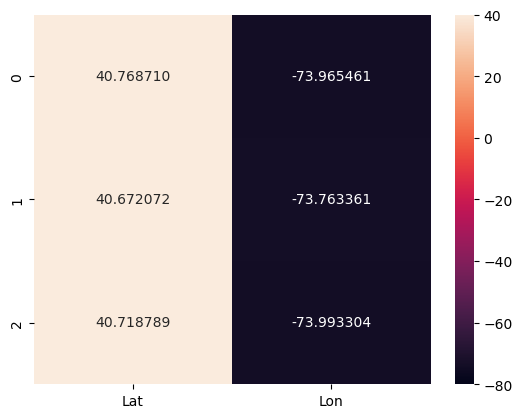

In [18]:
# Cluster centers coordinates
# Let's use inverse transform to have the real coordinates 
cluster_centers = sc.inverse_transform(kmeans.cluster_centers_[:,:2])

# Let's get column names to facilita understanding 
labels = column_names[:2]

# Let's visualize on a heatmap 
## Import Seaborn and pandas 
import seaborn as sns

# Create a heatmap 
sns.heatmap(pd.DataFrame(cluster_centers, columns=labels), annot=True, fmt='4f', vmin=-80, vmax=40)

In [19]:
print(cluster_centers)
print(labels)

[[ 40.76870978 -73.96546148]
 [ 40.67207193 -73.76336131]
 [ 40.71878925 -73.99330436]]
['Lat', 'Lon']


In [20]:
center = pd.DataFrame(cluster_centers, columns=labels)
center = center.reset_index()
center['index'] = center['index'].apply(lambda x: str(x))
center

index        Lat        Lon
0     0  40.768710 -73.965461
1     1  40.672072 -73.763361
2     2  40.718789 -73.993304

In [21]:
fig = px.scatter_mapbox(center, lat="Lat", lon="Lon", color='index', zoom=10, mapbox_style="carto-positron")
fig.update_traces(marker={'size': 15})
fig.show()

In [22]:
data_sample.loc[:,'Cluster_KMeans_A1'] = kmeans.predict(X)
data_sample['Cluster_KMeans_A1'] = data_sample['Cluster_KMeans_A1'].apply(lambda x: str(x))
data_sample.head()

Lat      Lon    Base           Timestamp  Dayofweek  Hour  \
1429384  40.7639 -73.9558  B02598 2014-06-22 16:46:00          6    16   
641888   40.7366 -73.9890  B02598 2014-05-06 07:43:00          1     7   
1410487  40.6868 -73.9842  B02598 2014-06-20 04:31:00          4     4   
1422669  40.7158 -74.0165  B02598 2014-06-21 17:31:00          5    17   
2503129  40.7213 -73.9976  B02682 2014-07-07 15:30:00          0    15   

        Cluster_KMeans_A1  
1429384                 0  
641888                  2  
1410487                 2  
1422669                 2  
2503129                 2

In [23]:
fig = px.scatter_mapbox(data_sample, lat="Lat", lon="Lon", color="Cluster_KMeans_A1", mapbox_style="carto-positron")
fig.show()

In [24]:
# Visualisation dans l'espace des trois variables quantitatives
fig = px.scatter_3d(data_sample, x = 'Lat', y = "Lon", z = 'Base', color = "Cluster_KMeans_A1")
fig.show()

#### Select $K$ optimal clusters 
#### Elbow method

In [25]:
# Let's create a loop that will collect the Within-sum-of-square (wcss) for each value K 
# Let's use .inertia_ parameter to get the within sum of square value for each value K 
wcss =  []
k = []
for i in range (1,11): 
    kmeans = KMeans(n_clusters= i, random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    k.append(i)
    print("WCSS for K={} --> {}".format(i, wcss[-1]))

/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



WCSS for K=1 --> 26803.756900000008


/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



WCSS for K=2 --> 21059.56009437868


/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



WCSS for K=3 --> 16958.199063598928


/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



WCSS for K=4 --> 15020.107480911665


/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



WCSS for K=5 --> 13107.718664018239


/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



WCSS for K=6 --> 11338.572137358658


/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



WCSS for K=7 --> 10073.938647917064


/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



WCSS for K=8 --> 8981.996158334598


/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



WCSS for K=9 --> 8310.939860363867


/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



WCSS for K=10 --> 7705.2849871588005


In [26]:
# Let's visualize using plotly
import plotly.express as px

# Create DataFrame
wcss_frame = pd.DataFrame(wcss)
k_frame = pd.Series(k)

# Create figure
fig= px.line(
    wcss_frame,
    x=k_frame,
    y=wcss_frame.iloc[:,-1]
)

# Create title and axis labels
fig.update_layout(
    yaxis_title="Inertia",
    xaxis_title="# Clusters",
    title="Inertia per cluster"
)

# Render
#fig.show(renderer="notebook")
fig.show() #(renderer="iframe") # if using workspace

In [27]:
# on peut supposer un bon nombre K de clusters entre 3 et 8 : il faut regarder la silhouette la plus élevée

#### Silhouette

In [28]:
# Import silhouette score
from sklearn.metrics import silhouette_score

# Computer mean silhouette score
sil = []
k = []

## Careful, you need to start at i=2 as silhouette score cannot accept less than 2 labels 
for i in range (2,11): 
    kmeans = KMeans(n_clusters= i, random_state = 0)
    kmeans.fit(X)
    sil.append(silhouette_score(X, kmeans.predict(X)))
    k.append(i)
    print("Silhouette score for K={} is {}".format(i, sil[-1]))

/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette score for K=2 is 0.6157192303054142


/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette score for K=3 is 0.22411042938156334


/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette score for K=4 is 0.2686593856684818


/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette score for K=5 is 0.3596544605914172


/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette score for K=6 is 0.39587214105575186


/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette score for K=7 is 0.39175778784821125


/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette score for K=8 is 0.40347942128447367


/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette score for K=9 is 0.4048595655952755


/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette score for K=10 is 0.3928332381810277


In [29]:
# Create a data frame 
cluster_scores=pd.DataFrame(sil)
k_frame = pd.Series(k)

# Create figure
fig = px.bar(data_frame=cluster_scores,  
            x=k, 
            y=cluster_scores.iloc[:, -1]
            )

# Add title and axis labels
fig.update_layout(
    yaxis_title="Silhouette Score",
    xaxis_title="# Clusters",
    title="Silhouette Score per cluster"
)

# Render
#fig.show(renderer="notebook")
fig.show() #(renderer="iframe") # if using workspace

In [30]:
# le nombre K optimal de clusters semble être 7

#### Train KMeans with K = 7

In [31]:
# Instanciate KMeans with k=3 and initialisation with k-means++
# You should always use k-means++ as it alleviate the problem of local minimum convergence 
kmeans = KMeans(n_clusters=7, random_state=0)

# Fit kmeans to our dataset
kmeans.fit(X)

/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(n_clusters=7, random_state=0)

In [32]:
# distance (inertie) entre centre du cluster et point le plus loin dans le cluster
print(kmeans.inertia_)
# cluster attribué pour chaque point
print(kmeans.labels_)
print(np.unique(kmeans.labels_))
# coordonnées (normalisées) du centre de chaque cluster
print(kmeans.cluster_centers_)

10073.938647917064
[4 4 2 ... 3 1 4]
[0 1 2 3 4 5 6]
[[ 4.27696847e+00  6.22017596e+00  2.22222222e-01  2.66666667e-01
   3.33333333e-01  6.66666667e-02]
 [ 6.67506439e-02 -2.48710500e-01 -1.38777878e-15 -2.05391260e-15
   7.45806933e-01  1.36414461e-01]
 [-1.60143473e+00 -3.07415238e-01  2.68722467e-01  3.50220264e-01
   2.36784141e-01  1.03524229e-01]
 [-1.93027298e+00  3.21329691e+00  3.08868502e-01  2.99694190e-01
   2.87461774e-01  7.03363914e-02]
 [ 5.32606874e-02 -2.39011162e-01  1.00000000e+00 -2.05391260e-15
  -3.88578059e-16 -1.94289029e-16]
 [ 6.87679777e-02 -2.42578152e-01 -1.05471187e-15  1.00000000e+00
  -3.88578059e-16 -1.73472348e-16]
 [ 1.25594169e+00  7.08961141e-01  3.21492007e-01  2.88632327e-01
   2.11367673e-01  8.96980462e-02]]


In [33]:
# Cluster centers coordinates
# Let's use inverse transform to have the real coordinates 
cluster_centers = sc.inverse_transform(kmeans.cluster_centers_[:,:2])

In [34]:
center = pd.DataFrame(cluster_centers, columns=labels)
center = center.reset_index()
center['index'] = center['index'].apply(lambda x: str(x))
center

index        Lat        Lon
0     0  40.912927 -73.600256
1     1  40.742088 -73.987306
2     2  40.674397 -73.990819
3     3  40.661054 -73.780165
4     4  40.741540 -73.986726
5     5  40.742170 -73.986939
6     6  40.790342 -73.930006

In [35]:
fig = px.scatter_mapbox(center, lat="Lat", lon="Lon", color='index', zoom=10, mapbox_style="carto-positron") # size="car_hours"
fig.update_traces(marker={'size': 15})
fig.show()

In [36]:
data_sample.loc[:,'Cluster_KMeans_A2'] = kmeans.predict(X)
data_sample['Cluster_KMeans_A2'] = data_sample['Cluster_KMeans_A2'].apply(lambda x: str(x))
data_sample.head()

Lat      Lon    Base           Timestamp  Dayofweek  Hour  \
1429384  40.7639 -73.9558  B02598 2014-06-22 16:46:00          6    16   
641888   40.7366 -73.9890  B02598 2014-05-06 07:43:00          1     7   
1410487  40.6868 -73.9842  B02598 2014-06-20 04:31:00          4     4   
1422669  40.7158 -74.0165  B02598 2014-06-21 17:31:00          5    17   
2503129  40.7213 -73.9976  B02682 2014-07-07 15:30:00          0    15   

        Cluster_KMeans_A1 Cluster_KMeans_A2  
1429384                 0                 4  
641888                  2                 4  
1410487                 2                 2  
1422669                 2                 4  
2503129                 2                 1

In [37]:
fig = px.scatter_mapbox(data_sample, lat="Lat", lon="Lon", color="Cluster_KMeans_A2", mapbox_style="carto-positron")
fig.show()

In [38]:
# Visualisation dans l'espace des trois variables quantitatives
fig = px.scatter_3d(data_sample, x = 'Lat', y = "Lon", z = 'Base', color = "Cluster_KMeans_A2")
fig.show()

In [39]:
# les clusters 0 et 1 sont beaucoup impactés par les bases, la B02598 pour le 0, la B02682 pour le 1.
# les autres clusters ne semblent pas dépendre de la feature 'Base' car ils comprennent plusieurs valeurs de base. Ils semblent principalement dépendre des coordonnées géographiques.
# les clusters 0, 1 et 6 se superposent géographiquement mais sur des base différentes.
# il peut être intéressant d'essayer un clustering KMeans de K = 5, puisqu'il y a 5 bases différentes

#### Train KMeans with K = 5

In [40]:
# Instanciate KMeans with k=3 and initialisation with k-means++
# You should always use k-means++ as it alleviate the problem of local minimum convergence 
kmeans = KMeans(n_clusters=5, random_state=0)

# Fit kmeans to our dataset
kmeans.fit(X)

/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(n_clusters=5, random_state=0)

In [41]:
cluster_centers = sc.inverse_transform(kmeans.cluster_centers_[:,:2])
center = pd.DataFrame(cluster_centers, columns=labels)
center = center.reset_index()
center['index'] = center['index'].apply(lambda x: str(x))
center

index        Lat        Lon
0     0  40.734242 -73.988389
1     1  40.665912 -73.769765
2     2  40.788525 -73.938262
3     3  40.731090 -73.989300
4     4  40.733851 -73.988004

In [42]:
fig = px.scatter_mapbox(center, lat="Lat", lon="Lon", color='index', zoom=10, mapbox_style="carto-positron") # size="car_hours"
fig.update_traces(marker={'size': 15})
fig.show()

In [43]:
data_sample.loc[:,'Cluster_KMeans_A3'] = kmeans.predict(X)
data_sample['Cluster_KMeans_A3'] = data_sample['Cluster_KMeans_A3'].apply(lambda x: str(x))
data_sample.head()

Lat      Lon    Base           Timestamp  Dayofweek  Hour  \
1429384  40.7639 -73.9558  B02598 2014-06-22 16:46:00          6    16   
641888   40.7366 -73.9890  B02598 2014-05-06 07:43:00          1     7   
1410487  40.6868 -73.9842  B02598 2014-06-20 04:31:00          4     4   
1422669  40.7158 -74.0165  B02598 2014-06-21 17:31:00          5    17   
2503129  40.7213 -73.9976  B02682 2014-07-07 15:30:00          0    15   

        Cluster_KMeans_A1 Cluster_KMeans_A2 Cluster_KMeans_A3  
1429384                 0                 4                 4  
641888                  2                 4                 4  
1410487                 2                 2                 4  
1422669                 2                 4                 4  
2503129                 2                 1                 0

In [44]:
fig = px.scatter_mapbox(data_sample, lat="Lat", lon="Lon", color="Cluster_KMeans_A3", mapbox_style="carto-positron")
fig.show()

In [45]:
# Visualisation dans l'espace des trois variables quantitatives
fig = px.scatter_3d(data_sample, x = 'Lat', y = "Lon", z = 'Base', color = "Cluster_KMeans_A3")
fig.show()

In [46]:
# ici encore, les clusters 0, 1 et 4 semblent se superposer géographiquement, mais se répartir en fonction des bases

### DBScan - without Day and Hour
#### Preprocessing

In [47]:
# DBScan permits to remove outlier

In [48]:
X = data_sample[['Lat', 'Lon', 'Base']]
X.head()

Lat      Lon    Base
1429384  40.7639 -73.9558  B02598
641888   40.7366 -73.9890  B02598
1410487  40.6868 -73.9842  B02598
1422669  40.7158 -74.0165  B02598
2503129  40.7213 -73.9976  B02682

In [49]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['Lat', 'Lon']
Found categorical features  ['Base']


/var/folders/5n/p64q8ht13qzd7qbp48cbvk880000gn/T/ipykernel_1483/2249989688.py:4: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [50]:
# Création du pipeline pour les variables quantitatives
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()) # pour normaliser les variables
])

# Création du pipeline pour les variables catégorielles
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # on encode les catégories sous forme de colonnes comportant des 0 et des 1
    ])

# On combine les pipelines dans un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings sur le dataset
print("Preprocessing sur le train set...")
print(X.head())
X = preprocessor.fit_transform(X) # fit_transform !!
print('...Terminé.')
print(X[0:5, :])
print()

Preprocessing sur le train set...
             Lat      Lon    Base
1429384  40.7639 -73.9558  B02598
641888   40.7366 -73.9890  B02598
1410487  40.6868 -73.9842  B02598
1422669  40.7158 -74.0165  B02598
2503129  40.7213 -73.9976  B02682
...Terminé.
[[ 0.60429931  0.27786244  1.          0.          0.          0.        ]
 [-0.06849214 -0.27701842  1.          0.          0.          0.        ]
 [-1.29578205 -0.19679468  1.          0.          0.          0.        ]
 [-0.58109516 -0.7366336   1.          0.          0.          0.        ]
 [-0.44555109 -0.42075262  0.          0.          1.          0.        ]]



#### Train DBScan with eps 0.2 & min_samples 100

In [51]:
db = DBSCAN(eps=0.2, min_samples=100, metric="manhattan")
db.fit(X)

DBSCAN(eps=0.2, metric='manhattan', min_samples=100)

In [52]:
np.unique(db.labels_)

array([-1,  0,  1,  2])

In [53]:
data_sample["Cluster_DBScan_A1"] = db.labels_
data_sample['Cluster_DBScan_A1'] = data_sample['Cluster_DBScan_A1'].apply(lambda x: str(x))
data_sample.head()

Lat      Lon    Base           Timestamp  Dayofweek  Hour  \
1429384  40.7639 -73.9558  B02598 2014-06-22 16:46:00          6    16   
641888   40.7366 -73.9890  B02598 2014-05-06 07:43:00          1     7   
1410487  40.6868 -73.9842  B02598 2014-06-20 04:31:00          4     4   
1422669  40.7158 -74.0165  B02598 2014-06-21 17:31:00          5    17   
2503129  40.7213 -73.9976  B02682 2014-07-07 15:30:00          0    15   

        Cluster_KMeans_A1 Cluster_KMeans_A2 Cluster_KMeans_A3  \
1429384                 0                 4                 4   
641888                  2                 4                 4   
1410487                 2                 2                 4   
1422669                 2                 4                 4   
2503129                 2                 1                 0   

        Cluster_DBScan_A1  
1429384                 0  
641888                  0  
1410487                -1  
1422669                 0  
2503129                 1

In [54]:
fig = px.scatter_mapbox(
        data_sample[data_sample['Cluster_DBScan_A1'] != '-1'], 
        lat="Lat", 
        lon="Lon",
        color="Cluster_DBScan_A1",
        mapbox_style="carto-positron"
)

fig.show()

In [55]:
# Visualisation dans l'espace des trois variables quantitatives
fig = px.scatter_3d(data_sample[data_sample['Cluster_DBScan_A1'] != '-1'], x = 'Lat', y = "Lon", z = 'Base', color = "Cluster_DBScan_A1")
fig.show()

In [56]:
data_sample['Base'].unique()

array(['B02598', 'B02682', 'B02764', 'B02617', 'B02512'], dtype=object)

In [57]:
# on trouve des petits clusters, et ils semblent fortement influancés par les bases.
# tentons d'augmenter le rayon eps et la densité min_samples pour prendre moins en considérations les outliers.

#### Train DBScan with eps 0.5 & min_samples 500

In [58]:
db = DBSCAN(eps=0.5, min_samples=500, metric="manhattan")
db.fit(X)

DBSCAN(metric='manhattan', min_samples=500)

In [59]:
np.unique(db.labels_)

array([-1,  0,  1,  2])

In [60]:
data_sample["Cluster_DBScan_A2"] = db.labels_
data_sample['Cluster_DBScan_A2'] = data_sample['Cluster_DBScan_A2'].apply(lambda x: str(x))
data_sample.head()

Lat      Lon    Base           Timestamp  Dayofweek  Hour  \
1429384  40.7639 -73.9558  B02598 2014-06-22 16:46:00          6    16   
641888   40.7366 -73.9890  B02598 2014-05-06 07:43:00          1     7   
1410487  40.6868 -73.9842  B02598 2014-06-20 04:31:00          4     4   
1422669  40.7158 -74.0165  B02598 2014-06-21 17:31:00          5    17   
2503129  40.7213 -73.9976  B02682 2014-07-07 15:30:00          0    15   

        Cluster_KMeans_A1 Cluster_KMeans_A2 Cluster_KMeans_A3  \
1429384                 0                 4                 4   
641888                  2                 4                 4   
1410487                 2                 2                 4   
1422669                 2                 4                 4   
2503129                 2                 1                 0   

        Cluster_DBScan_A1 Cluster_DBScan_A2  
1429384                 0                 0  
641888                  0                 0  
1410487                -1                -1  
1422669                 0                 0  
2503129                 1                 1

In [61]:
fig = px.scatter_mapbox(
        data_sample[data_sample['Cluster_DBScan_A2'] != '-1'], 
        lat="Lat", 
        lon="Lon",
        color="Cluster_DBScan_A2",
        mapbox_style="carto-positron"
)

fig.show()

In [62]:
# Visualisation dans l'espace des trois variables quantitatives
fig = px.scatter_3d(data_sample[data_sample['Cluster_DBScan_A2'] != '-1'], x = 'Lat', y = "Lon", z = 'Base', color = "Cluster_DBScan_A2")
fig.show()

In [63]:
clusters = []
lat_cent = []
lon_cent = []

for el in np.unique(db.labels_):
    if el < 0 : 
        pass
    else:
        x = data_sample[data_sample['Cluster_DBScan_A2'] == str(el)]
        clusters.append(el)
        lat_cent.append(x['Lat'].mean())
        lon_cent.append(x['Lon'].mean())

dict_centroid = {
    'cluster' : clusters,
    'lat' : lat_cent,
    'lng' : lon_cent
}
centroids_df = pd.DataFrame.from_dict(dict_centroid)
centroids_df

cluster        lat        lng
0        0  40.744554 -73.986471
1        1  40.744570 -73.987933
2        2  40.744100 -73.986959

In [64]:
fig = px.scatter_mapbox(centroids_df, lat="lat", lon="lng", color='cluster', zoom=10, mapbox_style="carto-positron")
fig.update_traces(marker={'size': 15})
fig.show()

Conclusion : 

La variable 'Base' prend trop d'importance dans nos modèles de clusturing pour déterminer les hot-zones. Nous allons recréer des modèles entrainés sans cette variable pour déterminer de meilleures hot-zones.

## Models without 'Base' for 1 day of the week

In [65]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)
data_sample.head()

Lat      Lon    Base           Timestamp  Dayofweek  Hour
2506383  40.7704 -73.9844  B02682 2014-07-08 07:08:00          1     7
1091550  40.7458 -73.9928  B02682 2014-05-15 11:40:00          3    11
2531657  40.6461 -73.7842  B02682 2014-07-11 16:52:00          4    16
1751115  40.7297 -74.0006  B02682 2014-06-12 03:52:00          3     3
3015182  40.7922 -73.9526  B02617 2014-08-07 21:57:00          3    21

In [66]:
day1_data = data_sample.loc[data_sample['Dayofweek'] == 0,:]
day1_data.head()

Lat      Lon    Base           Timestamp  Dayofweek  Hour
1498154  40.7356 -73.9969  B02617 2014-06-02 15:21:00          0    15
1578611  40.6998 -73.9910  B02617 2014-06-16 13:49:00          0    13
194671   40.7473 -74.0081  B02598 2014-04-28 17:06:00          0    17
3472611  40.7252 -73.9982  B02764 2014-08-18 16:11:00          0    16
2970180  40.7149 -73.9595  B02617 2014-08-04 13:56:00          0    13

#### Preprocessing

In [67]:
X = day1_data[['Lat', 'Lon']]
X.head()

Lat      Lon
1498154  40.7356 -73.9969
1578611  40.6998 -73.9910
194671   40.7473 -74.0081
3472611  40.7252 -73.9982
2970180  40.7149 -73.9595

In [68]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

# Création du pipeline pour les variables quantitatives
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()) # pour normaliser les variables
])

# Création du pipeline pour les variables catégorielles
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # on encode les catégories sous forme de colonnes comportant des 0 et des 1
    ])

# On combine les pipelines dans un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings sur le dataset
print("Preprocessing sur le train set...")
print(X.head())
X = preprocessor.fit_transform(X) # fit_transform !!
print('...Terminé.')
print(X[0:5, :])
print()

Found numeric features  ['Lat', 'Lon']
Found categorical features  []
Preprocessing sur le train set...
             Lat      Lon
1498154  40.7356 -73.9969
1578611  40.6998 -73.9910
194671   40.7473 -74.0081
3472611  40.7252 -73.9982
2970180  40.7149 -73.9595
...Terminé.
[[-0.10274431 -0.47903952]
 [-0.99739917 -0.37112963]
 [ 0.18964289 -0.68388541]
 [-0.36264405 -0.50281627]
 [-0.62004475  0.20499943]]



/var/folders/5n/p64q8ht13qzd7qbp48cbvk880000gn/T/ipykernel_1483/4255551742.py:4: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



### KMeans
#### Select $K$ optimal clusters 
#### Elbow method

In [69]:
# Let's create a loop that will collect the Within-sum-of-square (wcss) for each value K 
# Let's use .inertia_ parameter to get the within sum of square value for each value K 
wcss =  []
k = []
for i in range (1,11): 
    kmeans = KMeans(n_clusters= i, random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    k.append(i)
    print("WCSS for K={} --> {}".format(i, wcss[-1]))


# Let's visualize using plotly
import plotly.express as px

# Create DataFrame
wcss_frame = pd.DataFrame(wcss)
k_frame = pd.Series(k)

# Create figure
fig= px.line(
    wcss_frame,
    x=k_frame,
    y=wcss_frame.iloc[:,-1]
)

# Create title and axis labels
fig.update_layout(
    yaxis_title="Inertia",
    xaxis_title="# Clusters",
    title="Inertia per cluster"
)

# Render
#fig.show(renderer="notebook")
fig.show() #(renderer="iframe") # if using workspace

/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/geoffrey_quillet/anaconda3/li

WCSS for K=1 --> 2430.0
WCSS for K=2 --> 1515.7731619829046
WCSS for K=3 --> 984.8480301278119
WCSS for K=4 --> 771.959140899052
WCSS for K=5 --> 623.5991029379827
WCSS for K=6 --> 518.6848306872445
WCSS for K=7 --> 431.8572542069265
WCSS for K=8 --> 378.50680261597336
WCSS for K=9 --> 324.83941966680584
WCSS for K=10 --> 274.2898658956051


/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



#### Silhouette

In [70]:
# Import silhouette score
from sklearn.metrics import silhouette_score

# Computer mean silhouette score
sil = []
k = []

## Careful, you need to start at i=2 as silhouette score cannot accept less than 2 labels 
for i in range (2,11): 
    kmeans = KMeans(n_clusters= i, random_state = 0)
    kmeans.fit(X)
    sil.append(silhouette_score(X, kmeans.predict(X)))
    k.append(i)
    print("Silhouette score for K={} is {}".format(i, sil[-1]))



# Create a data frame 
cluster_scores=pd.DataFrame(sil)
k_frame = pd.Series(k)

# Create figure
fig = px.bar(data_frame=cluster_scores,  
            x=k, 
            y=cluster_scores.iloc[:, -1]
            )

# Add title and axis labels
fig.update_layout(
    yaxis_title="Silhouette Score",
    xaxis_title="# Clusters",
    title="Silhouette Score per cluster"
)

# Render
#fig.show(renderer="notebook")
fig.show() #(renderer="iframe") # if using workspace

/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette score for K=2 is 0.7233091121590955
Silhouette score for K=3 is 0.4301606438297798


/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette score for K=4 is 0.4463077026447362


/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette score for K=5 is 0.455934971504058
Silhouette score for K=6 is 0.46575310970751904


/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette score for K=7 is 0.482772468242106
Silhouette score for K=8 is 0.43622944136975306


/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette score for K=9 is 0.4396267309893414
Silhouette score for K=10 is 0.44298094572330754


/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [71]:
# the best k seems to be 4
# the elbow seems to be between 3 and 4.
# the best silhouette between 3 and 4 is 4.

#### Train KMeans with K = 4

In [72]:
# Instanciate KMeans with k=3 and initialisation with k-means++
# You should always use k-means++ as it alleviate the problem of local minimum convergence 
kmeans = KMeans(n_clusters=4, random_state=0)

# Fit kmeans to our dataset
kmeans.fit(X)

/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(n_clusters=4, random_state=0)

In [73]:
# distance (inertie) entre centre du cluster et point le plus loin dans le cluster
print(kmeans.inertia_)
# cluster attribué pour chaque point
print(kmeans.labels_)
print(np.unique(kmeans.labels_))
# coordonnées (normalisées) du centre de chaque cluster
print(kmeans.cluster_centers_)

771.959140899052
[1 3 1 ... 1 3 1]
[0 1 2 3]
[[ 1.39162816  1.16870454]
 [ 0.43689389 -0.1836717 ]
 [-1.97659688  3.52660176]
 [-0.76522482 -0.44036963]]


In [74]:
# Cluster centers coordinates
# Let's use inverse transform to have the real coordinates 
cluster_centers = sc.inverse_transform(kmeans.cluster_centers_[:,:2])
cluster_centers

array([[ 40.79584761, -73.90249854],
       [ 40.75710716, -73.98341482],
       [ 40.65917443, -73.76141927],
       [ 40.70832853, -73.99877374]])

In [75]:
center = pd.DataFrame(cluster_centers, columns=labels)
center = center.reset_index()
center['index'] = center['index'].apply(lambda x: str(x))
center.head()


fig = px.scatter_mapbox(center, lat="Lat", lon="Lon", color='index', zoom=10, mapbox_style="carto-positron") # size="car_hours"
fig.update_traces(marker={'size': 15})
fig.show()

In [76]:
day1_data.loc[:,'Cluster_KMeans_B1'] = kmeans.predict(X)
day1_data['Cluster_KMeans_B1'] = day1_data['Cluster_KMeans_B1'].apply(lambda x: str(x))
day1_data.head()


fig = px.scatter_mapbox(day1_data, lat="Lat", lon="Lon", color="Cluster_KMeans_B1", mapbox_style="carto-positron")
fig.show()

/var/folders/5n/p64q8ht13qzd7qbp48cbvk880000gn/T/ipykernel_1483/3277295904.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/5n/p64q8ht13qzd7qbp48cbvk880000gn/T/ipykernel_1483/3277295904.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### DBScan

In [77]:
db = DBSCAN(eps=0.25, min_samples=20, metric="manhattan")
db.fit(X)

DBSCAN(eps=0.25, metric='manhattan', min_samples=20)

In [78]:
np.unique(db.labels_)

array([-1,  0,  1,  2,  3])

In [79]:
day1_data["Cluster_DBScan_B1"] = db.labels_
day1_data['Cluster_DBScan_B1'] = day1_data['Cluster_DBScan_B1'].apply(lambda x: str(x))
day1_data.head()

/var/folders/5n/p64q8ht13qzd7qbp48cbvk880000gn/T/ipykernel_1483/968307361.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/5n/p64q8ht13qzd7qbp48cbvk880000gn/T/ipykernel_1483/968307361.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Lat      Lon    Base           Timestamp  Dayofweek  Hour  \
1498154  40.7356 -73.9969  B02617 2014-06-02 15:21:00          0    15   
1578611  40.6998 -73.9910  B02617 2014-06-16 13:49:00          0    13   
194671   40.7473 -74.0081  B02598 2014-04-28 17:06:00          0    17   
3472611  40.7252 -73.9982  B02764 2014-08-18 16:11:00          0    16   
2970180  40.7149 -73.9595  B02617 2014-08-04 13:56:00          0    13   

        Cluster_KMeans_B1 Cluster_DBScan_B1  
1498154                 1                 0  
1578611                 3                -1  
194671                  1                 0  
3472611                 3                 0  
2970180                 3                 1

In [80]:
fig = px.scatter_mapbox(
        day1_data[day1_data['Cluster_DBScan_B1'] != '-1'], 
        lat="Lat", 
        lon="Lon",
        color="Cluster_DBScan_B1",
        mapbox_style="carto-positron"
)
fig.show()

In [81]:
clusters = []
lat_cent = []
lon_cent = []

for el in np.unique(db.labels_):
    if el < 0 : 
        pass
    else:
        x = day1_data[day1_data['Cluster_DBScan_B1'] == str(el)]
        clusters.append(el)
        lat_cent.append(x['Lat'].mean())
        lon_cent.append(x['Lon'].mean())

dict_centroid = {
    'cluster' : clusters,
    'lat' : lat_cent,
    'lng' : lon_cent
}
centroids_df = pd.DataFrame.from_dict(dict_centroid)
centroids_df

cluster        lat        lng
0        0  40.747114 -73.986593
1        1  40.713924 -73.959938
2        2  40.772517 -73.870513
3        3  40.645073 -73.783998

In [106]:
fig = px.scatter_mapbox(centroids_df, lat="lat", lon="lng", color='cluster', zoom=10, mapbox_style="carto-positron")
fig.update_traces(marker={'size': 15})
fig.show()

## Models for all days

In [83]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)
data_sample = data_sample.sort_values(by='Dayofweek')
data_sample.head()

Lat      Lon    Base           Timestamp  Dayofweek  Hour
4057623  40.7200 -73.9990  B02617 2014-09-22 08:55:00          0     8
3662804  40.7329 -74.0075  B02598 2014-09-15 20:57:00          0    20
68475    40.7095 -74.0109  B02598 2014-04-07 16:49:00          0    16
1382110  40.7375 -73.9204  B02598 2014-06-16 21:04:00          0    21
3879494  40.7575 -74.0043  B02617 2014-09-08 16:39:00          0    16

In [84]:
sc = StandardScaler()
list_of_days = data_sample['Dayofweek'].unique().tolist()
list_of_days.sort()
print(list_of_days)

[0, 1, 2, 3, 4, 5, 6]


### KMeans

In [111]:
for el in list_of_days:
    all_day_data = data_sample[data_sample['Dayofweek'] == el]
    X = all_day_data[['Lat', 'Lon']]
    X = sc.fit_transform(X)
    kmeans = KMeans(n_clusters=4, random_state=0)
    kmeans.fit(X)
    cluster_centers = sc.inverse_transform(kmeans.cluster_centers_)
    if el == 0:
        pred = list(kmeans.predict(X))
        center = pd.DataFrame(cluster_centers, columns=labels)
        center['day'] = el
    else:
        pred = pred + list(kmeans.predict(X))
        center_bis = pd.DataFrame(cluster_centers, columns=labels)
        center_bis['day'] = el
        center = pd.concat((center, center_bis), axis=0)

data_sample['KMeans_Cluster_day'] = pred
data_sample['KMeans_Cluster_day'] = data_sample['KMeans_Cluster_day'].apply(lambda x: str(x))
center = center.reset_index()
center['index'] = center['index'].apply(lambda x: str(x))

/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/geoffrey_quillet/anaconda3/li

In [112]:
fig = px.scatter_mapbox(data_sample, lat="Lat", lon="Lon", color="KMeans_Cluster_day", mapbox_style="carto-positron", 
                        animation_frame = 'Dayofweek', title="KMeans clusters per day")
fig.show()

In [113]:
fig = px.scatter_mapbox(center, lat="Lat", lon="Lon", color="index", mapbox_style="carto-positron", 
                        animation_frame = 'day', title="KMeans clusters centroïd per day")
fig.update_traces(marker={'size': 15})
fig.show()

### DBScan

In [87]:
for el in list_of_days:
    all_day_data = data_sample[data_sample['Dayofweek'] == el]
    X = all_day_data[['Lat', 'Lon']]
    X = sc.fit_transform(X)
    db = DBSCAN(eps=0.25, min_samples=20, metric="manhattan")
    db.fit(X)
    if el == 0:
        pred = list(db.labels_)
    else:
        pred = pred + list(db.labels_)

data_sample['DBS_Cluster_day'] = pred
data_sample['DBS_Cluster_day'] = data_sample['DBS_Cluster_day'].apply(lambda x: str(x))

In [88]:
fig = px.scatter_mapbox(data_sample[data_sample['KMeans_Cluster_day'] != '-1'], lat="Lat", lon="Lon", color="KMeans_Cluster_day", mapbox_style="carto-positron", 
                        animation_frame = 'Dayofweek', title="DBScan clusters per day")
fig.show()

## Models for all hours

In [89]:
data_sample = data_sample.sort_values(by='Hour')
data_sample.head()

Lat      Lon    Base           Timestamp  Dayofweek  Hour  \
1616638  40.7234 -73.9883  B02617 2014-06-22 00:53:00          6     0   
494048   40.7337 -74.0063  B02682 2014-04-24 00:40:00          3     0   
601364   40.7051 -74.0100  B02598 2014-05-01 00:36:00          3     0   
2903313  40.7150 -73.9920  B02598 2014-08-28 00:48:00          3     0   
2457719  40.6469 -73.7895  B02617 2014-07-31 00:49:00          3     0   

        KMeans_Cluster_day DBS_Cluster_day  
1616638                  3               1  
494048                   0               1  
601364                   0               1  
2903313                  0               1  
2457719                  3               0

In [90]:
list_of_hours = data_sample['Hour'].unique().tolist()
list_of_hours.sort()
print(list_of_hours)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


### KMeans

In [114]:
for el in list_of_hours:
    all_day_data = data_sample[data_sample['Hour'] == el]
    X = all_day_data[['Lat', 'Lon']]
    X = sc.fit_transform(X)
    kmeans = KMeans(n_clusters=4, random_state=0)
    kmeans.fit(X)
    if el == 0:
        pred = list(kmeans.predict(X))
        center = pd.DataFrame(cluster_centers, columns=labels)
        center['hour'] = el
    else:
        pred = pred + list(kmeans.predict(X))
        center_bis = pd.DataFrame(cluster_centers, columns=labels)
        center_bis['hour'] = el
        center = pd.concat((center, center_bis), axis=0)

data_sample['KMeans_Cluster_hour'] = pred
data_sample['KMeans_Cluster_hour'] = data_sample['KMeans_Cluster_hour'].apply(lambda x: str(x))
center = center.reset_index()
center['index'] = center['index'].apply(lambda x: str(x))

/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/geoffrey_quillet/anaconda3/li

In [115]:
fig = px.scatter_mapbox(data_sample, lat="Lat", lon="Lon", color="KMeans_Cluster_hour", mapbox_style="carto-positron", 
                        animation_frame = 'Hour', title="KMeans clusters per hour")
fig.show()

In [116]:
fig = px.scatter_mapbox(center, lat="Lat", lon="Lon", color="index", mapbox_style="carto-positron", 
                        animation_frame = 'hour', title="KMeans clusters centroïd per hour")
fig.update_traces(marker={'size': 15})
fig.show()

### DBScan

In [93]:
for el in list_of_hours:
    all_day_data = data_sample[data_sample['Hour'] == el]
    X = all_day_data[['Lat', 'Lon']]
    X = sc.fit_transform(X)
    db = DBSCAN(eps=0.25, min_samples=20, metric="manhattan")
    db.fit(X)
    if el == 0:
        pred = list(db.labels_)
    else:
        pred = pred + list(db.labels_)

data_sample['DBS_Cluster_hour'] = pred
data_sample['DBS_Cluster_hour'] = data_sample['DBS_Cluster_hour'].apply(lambda x: str(x))

In [94]:
fig = px.scatter_mapbox(data_sample[data_sample['DBS_Cluster_hour'] != '-1'], lat="Lat", lon="Lon", color="DBS_Cluster_hour", mapbox_style="carto-positron", 
                        animation_frame = 'Hour', title="DBScan clusters per hour")
fig.show()

## Models for each hour of each day of the week

In [95]:
data_sample = data_sample.sort_values(by=['Dayofweek' ,'Hour'])
data_sample.head(200)

Lat      Lon    Base           Timestamp  Dayofweek  Hour  \
813946   40.7159 -73.9452  B02598 2014-05-26 00:23:00          0     0   
4055115  40.7368 -73.9800  B02617 2014-09-22 00:02:00          0     0   
2594945  40.7470 -73.9935  B02682 2014-07-21 00:28:00          0     0   
1255724  40.7161 -73.9620  B02598 2014-06-02 00:03:00          0     0   
1376324  40.7631 -73.9938  B02598 2014-06-16 00:33:00          0     0   
...          ...      ...     ...                 ...        ...   ...   
1622088  40.7732 -73.8855  B02617 2014-06-23 07:07:00          0     7   
3967447  40.7027 -73.9828  B02617 2014-09-15 07:46:00          0     7   
528018   40.7592 -73.9957  B02682 2014-04-28 07:07:00          0     7   
2198010  40.7937 -73.9729  B02617 2014-07-07 07:24:00          0     7   
527985   40.7731 -73.8859  B02682 2014-04-28 07:02:00          0     7   

        KMeans_Cluster_day DBS_Cluster_day KMeans_Cluster_hour  \
813946                   0              -1                   0   
4055115                  0               0                   1   
2594945                  3               0                   1   
1255724                  0              -1                   0   
1376324                  3               0                   1   
...                    ...             ...                 ...   
1622088                  3               2                   1   
3967447                  0              -1                   2   
528018                   3               0                   3   
2198010                  3               0                   1   
527985                   3               2                   1   

        DBS_Cluster_hour  
813946                 2  
4055115                0  
2594945                0  
1255724                2  
1376324                1  
...                  ...  
1622088               -1  
3967447               -1  
528018                 0  
2198010                0  
527985                -1  

[200 rows x 10 columns]

In [96]:
data_sample['D&H'] = ('D' + data_sample['Dayofweek'].apply(lambda x: str(x)) + '-H' + data_sample['Hour'].apply(lambda x: str(x)))
data_sample.head()

Lat      Lon    Base           Timestamp  Dayofweek  Hour  \
813946   40.7159 -73.9452  B02598 2014-05-26 00:23:00          0     0   
4055115  40.7368 -73.9800  B02617 2014-09-22 00:02:00          0     0   
2594945  40.7470 -73.9935  B02682 2014-07-21 00:28:00          0     0   
1255724  40.7161 -73.9620  B02598 2014-06-02 00:03:00          0     0   
1376324  40.7631 -73.9938  B02598 2014-06-16 00:33:00          0     0   

        KMeans_Cluster_day DBS_Cluster_day KMeans_Cluster_hour  \
813946                   0              -1                   0   
4055115                  0               0                   1   
2594945                  3               0                   1   
1255724                  0              -1                   0   
1376324                  3               0                   1   

        DBS_Cluster_hour    D&H  
813946                 2  D0-H0  
4055115                0  D0-H0  
2594945                0  D0-H0  
1255724                2  D0-H0  
1376324                1  D0-H0

### KMeans

In [117]:
for i in list_of_hours:
    for j in list_of_hours:
        all_dh_data = data_sample[(data_sample['Dayofweek'] == i) & (data_sample['Hour'] == j)]
        if len(all_dh_data) < 1:
            if (i, j) == (0, 0):
                pred = [-1] * len(all_dh_data)
            else:
                pred = pred + ([-1] * len(all_dh_data))
        else:
            X = all_dh_data[['Lat', 'Lon']]
            X = sc.fit_transform(X)
            kmeans = KMeans(n_clusters=4, random_state=0)
            kmeans.fit(X)
            if (i, j) == (0, 0):
                pred = list(kmeans.predict(X))
                center = pd.DataFrame(cluster_centers, columns=labels)
                center['d&h'] = 'D' + str(i) + '-H' + str(j)

            else:
                pred = pred + list(kmeans.predict(X))
                center_bis = pd.DataFrame(cluster_centers, columns=labels)
                center_bis['d&h'] = 'D' + str(i) + '-H' + str(j)
                center = pd.concat((center, center_bis), axis=0)


data_sample['KMeans_Cluster_day&hour'] = pred
data_sample['KMeans_Cluster_day&hour'] = data_sample['KMeans_Cluster_day&hour'].apply(lambda x: str(x))
center = center.reset_index()
center['index'] = center['index'].apply(lambda x: str(x))


/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/geoffrey_quillet/anaconda3/li

In [119]:
fig = px.scatter_mapbox(data_sample, lat="Lat", lon="Lon", color="KMeans_Cluster_day&hour", mapbox_style="carto-positron", 
                        animation_frame ='D&H', title="KMeans clusters per hour of the week")
fig.show()

In [120]:
fig = px.scatter_mapbox(center, lat="Lat", lon="Lon", color="index", mapbox_style="carto-positron", 
                        animation_frame = 'd&h', title="KMeans clusters centroïd per hour of the week")
fig.update_traces(marker={'size': 15})
fig.show()

### DBScan

In [99]:
for i in list_of_hours:
    for j in list_of_hours:
        all_dh_data = data_sample[(data_sample['Dayofweek'] == i) & (data_sample['Hour'] == j)]
        if len(all_dh_data) < 1:
            if (i, j) == (0, 0):
                pred = [-1] * len(all_dh_data)
            else:
                pred = pred + ([-1] * len(all_dh_data))
        else :
            X = all_dh_data[['Lat', 'Lon']]
            X = sc.fit_transform(X)
            db = DBSCAN(eps=0.2, min_samples=5, metric="manhattan")
            db.fit(X)
            if (i, j) == (0, 0):
                pred = list(db.labels_)
            else:
                pred = pred + list(db.labels_)

data_sample['DBS_Cluster_day&hour'] = pred
data_sample['DBS_Cluster_day&hour'] = data_sample['DBS_Cluster_day&hour'].apply(lambda x: str(x))

In [100]:
fig = px.scatter_mapbox(data_sample[data_sample['DBS_Cluster_day&hour'] != '-1'], lat="Lat", lon="Lon", color="DBS_Cluster_day&hour", mapbox_style="carto-positron", 
                        animation_frame = 'D&H', title="DBScan clusters per hour of the week")
fig.show()

In [101]:
for i in list_of_hours:
    for j in list_of_hours:
        all_dh_data = data_sample[(data_sample['Dayofweek'] == i) & (data_sample['Hour'] == j)]
        if len(all_dh_data) < 1:
            if (i, j) == (0, 0):
                pred = [-1] * len(all_dh_data)
            else:
                pred = pred + ([-1] * len(all_dh_data))
        else :
            X = all_dh_data[['Lat', 'Lon']]
            X = sc.fit_transform(X)
            db = DBSCAN(eps=0.25, min_samples=10, metric="manhattan")
            db.fit(X)
            if (i, j) == (0, 0):
                pred = list(db.labels_)
            else:
                pred = pred + list(db.labels_)

data_sample['DBS_Cluster_day&hour2'] = pred
data_sample['DBS_Cluster_day&hour2'] = data_sample['DBS_Cluster_day&hour2'].apply(lambda x: str(x))

In [102]:
fig = px.scatter_mapbox(data_sample[data_sample['DBS_Cluster_day&hour2'] != '-1'], lat="Lat", lon="Lon", color="DBS_Cluster_day&hour2", mapbox_style="carto-positron", 
                        animation_frame = 'D&H', title="DBScan clusters per hour of the week")
fig.show()

# Conclusion

With the 2 clustering methods DBScan and KMeans, we identified the hottest zones in New-York per hour and per day for Uber.
It will allow Uber to optimize their drivers position in function of cluters and their centroid so as to help reducing the user's waiting time.